# UFC Fight Scoring - Regression - Modeling and Visualization

## Import Libraries

In [90]:
from UFCStats.queries import DatabaseQuery

from datetime import datetime

import pandas as pd
import numpy as np
from scipy import stats
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import warnings
warnings.filterwarnings('ignore')

## Queries

In [91]:
# Run queries to add db data to pandas dataframes
DQ = DatabaseQuery()

def query_to_df(query):
    df = pd.DataFrame(query.fetchall())
    df.columns = query.keys()
    return df

event_dates_df = query_to_df(DQ.get_event_dates())

In [92]:
def query_to_df(query):
    df = pd.DataFrame(query.fetchall())
    df.columns = query.keys()
    return df

# Train Test Split

Rather than using the built in train test split functionality from sci-kit learn, I am opting for a time based split. Rather than splitting randomly, this instead splits based on the date of the fight. This ensures that the record for fighter_1 and fighter_2 for a given fight will both be in the same dataset (train or test). This allows for comparing the predicted score for each fighter and declaring the winner based on the relative scores. Absent this methodology, there will be fights where only one of the two fighters is present in the testing data, which means that a different methodolgy must be used to determine if the model correctly predicted the winner. Specifically, if the actual and predicted per round scored are both over 9.5 or both under 9.5, the model would assume it has made a correct prediction. 

In addition to a more reasonable winner prediction methodology, this split avoids other issues that may arise with including one half of a fight in the training dataset and the other half in the testing dataset. The nature of the data is such that fighter_1 and fighter_2 are mirror images of each other, because the features reflect the difference between fighter_1 and fighter_2. Including fighter_1 in the training data and using that to predict fighter_2 in the testing data is not the most fair methodology.

I chose date cutoffs that allowed for a 60/20/20 split for training, validation, and testing. Given that there have been no significant rule changes over the course of my dataset timeline, a time-based split appears reasonable.

# Baseline Regression Model

In [93]:
# Get clean data from pickle
with open('pickle_linear_reg_data.pickle', 'rb') as read_file:
    linear_reg_data_filtered = pickle.load(read_file)

In [94]:
# Add back identifiers for date merging
linear_reg_data_filtered['fight_id'] = linear_reg_data_filtered.index.copy()
linear_reg_data_filtered['fight_id'] = linear_reg_data_filtered['fight_id'].str.split('-').str[0]

# Get fight_id and event_id from Postgres, merge dates to regression data
fights_and_events = query_to_df(DQ.engine.execute('SELECT fight_id, event_id FROM fights'))

fight_dates_df = pd.merge(fights_and_events, 
                          event_dates_df,
                          how='left',
                          left_on='event_id',
                          right_on='event_id'
                         )

linear_reg_data_filtered = pd.merge(linear_reg_data_filtered, 
                                    fight_dates_df[['fight_id', 'event_date']],
                                    how='left',
                                    left_on='fight_id',
                                    right_on='fight_id'
                                   ).set_index(linear_reg_data_filtered.index)

In [95]:
# Slice data for before and after cutoff data for train test split
train_cutoff = '2017-07-20'
validation_cutoff = '2019-07-25'
before = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] < train_cutoff]
after = linear_reg_data_filtered[(linear_reg_data_filtered['event_date'] >= train_cutoff)
                                 &(linear_reg_data_filtered['event_date'] < validation_cutoff)]

In [96]:
# Split data to training and testing data using time based cutoff
x_train = before.drop(columns=['combined_avg', 'fight_id', 'event_date'], axis = 1)
x_test = after.drop(columns=['combined_avg', 'fight_id', 'event_date'], axis = 1)
y_train = before[['combined_avg']]
y_test = after[['combined_avg']]

In [97]:
# Instantiate and fit the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

# Print out the intercept and coefficients of the linear regression model
intercept = regression_model.intercept_[0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*70)

for coef in zip(x_test.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))
    
# Score the regression model (R^2)
reg_score = regression_model.score(x_test, y_test)
print('\n')
print('Linear Regression R-Squared: ' +str(format(reg_score, '.4f')))
reg_pred = regression_model.predict(x_test)
reg_rmse = mean_squared_error(y_test, np.where(reg_pred > 10.0, 10.0, reg_pred), squared=False)
print('Linear Regression RMSE:      ' +str(format(reg_rmse, '.4f')))

The intercept for our model is 9.487
----------------------------------------------------------------------
The Coefficient for kd_disparity is 0.2
The Coefficient for sig_head_land_disparity is 0.0021
The Coefficient for sig_strike_land_disparity is 0.015
The Coefficient for total_strike_att_disparity is 0.00099
The Coefficient for takedown_land_disparity is 0.11
The Coefficient for takedown_att_disparity is -0.029
The Coefficient for sub_att_disparity is 0.071
The Coefficient for ctrl_time_disparity is 0.0011


Linear Regression R-Squared: 0.6778
Linear Regression RMSE:      0.2096


### Polynomial Features

There were no obvious relationships in the pairplots to suggest that polynomials would have a significant impact. Given that the benefit from 2nd and 3rd degree polynomials is minimal, I will move forward with the simpler feature set.

In [98]:
# perform a polynomial features transform of the dataset
poly2 = PolynomialFeatures(degree=2)
x_test_poly2 = poly2.fit_transform(x_test)
x_train_poly2 = poly2.fit_transform(x_train)

regression_model.fit(x_train_poly2, y_train)

# Score the regression model (R^2)
reg_score = regression_model.score(x_test_poly2, y_test)
print('Linear Regression R-Squared: ' +str(format(reg_score, '.4f')))
reg_pred = regression_model.predict(x_test_poly2)
reg_rmse = mean_squared_error(y_test, np.where(reg_pred > 10.0, 10.0, reg_pred), squared=False)
print('Linear Regression RMSE:      ' +str(format(reg_rmse, '.4f')))

Linear Regression R-Squared: 0.6904
Linear Regression RMSE:      0.2075


In [99]:
# perform a polynomial features transform of the dataset
poly3 = PolynomialFeatures(degree=3)
x_test_poly3 = poly3.fit_transform(x_test)
x_train_poly3 = poly3.fit_transform(x_train)

regression_model.fit(x_train_poly3, y_train)

# Score the regression model (R^2)
reg_score = regression_model.score(x_test_poly3, y_test)
print('Linear Regression R-Squared: ' +str(format(reg_score, '.4f')))
reg_pred = regression_model.predict(x_test_poly3)
reg_rmse = mean_squared_error(y_test, np.where(reg_pred > 10.0, 10.0, reg_pred), squared=False)
print('Linear Regression RMSE:      ' +str(format(reg_rmse, '.4f')))

Linear Regression R-Squared: 0.6930
Linear Regression RMSE:      0.2081


# Cross Validation - All Models

I performed cross validation for Linear Regression, LASSO Regression, Ridge Regression, SGDRegressor, and Random Forest Regression models. I adjusuted LASSO, Ridge, and SGD hyperparamets manually to achieve a near optimal output. I also tested LassoCV and RidgeCV. For Random Forest hyperparameter tuning, scroll to the very bottom of this notebook. For all models, I tested performance using unaltered data, normalized data, and standardized data.

The best performing model was Random Forest, using normalized data, though all models were relatively close in terms of performance. I intend to bring forward Linear Regression (with normalized data) forward to the testing phase, as the model is very interpretable and not far off of peak performance.

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Train test split (time based)
x_train = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] <= validation_cutoff].drop(columns=['combined_avg', 'fight_id', 'event_date'], 
                                                                                                     axis = 1)
x_test = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] > validation_cutoff].drop(columns=['combined_avg', 'fight_id', 'event_date'], 
                                                                                                   axis = 1)
y_train = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] <= validation_cutoff][['combined_avg']]
y_test = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] > validation_cutoff][['combined_avg']]

# Normalized data
mm_scale = MinMaxScaler()
x_train_norm = mm_scale.fit_transform(x_train)
x_test_norm = mm_scale.transform(x_test)

# Standardized data
st_scale = StandardScaler()
x_train_st = st_scale.fit_transform(x_train)
x_test_st = st_scale.transform(x_test)

# Instantiate models
alphas = np.linspace(0.0001, 100, 1000)

#lasso_reg = LassoCV(alphas=alphas, max_iter=100000, tol=0.001, cv=5)
#ridge_reg = RidgeCV(alphas=alphas, cv=5)
lasso_reg = Lasso(alpha=.0001, max_iter=100000, tol=0.001)
ridge_reg = Ridge(alpha=.0001, max_iter=100000, tol=0.001)
sgd_reg = SGDRegressor(alpha=.0000001, max_iter=100000000, tol=0.0000001)
rf_reg = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='auto', min_samples_leaf=10, min_samples_split=20, n_estimators=300)

# Establish KFold for cross validation
kf = KFold(n_splits=5, shuffle=True, random_state = 13)

cross_validation_dict = {'model' : [],
                         'r2_mean' : [],
                         'r2_std' : [],
                         'rmse_mean' : [],
                         'rmse_std' : []
                        }

gen_error_dict = {'model' : [],
                  'train_r2' : [],
                  'validation_r2' : [],
                  'difference' : [],
                 }

In [101]:
def calc_cross_val(model, model_string, x_train, y_train):
    """
    Populate cross validation dictionary to be passed to a summary dataframe.
    """
    
    cross_val_r2 = cross_val_score(model, x_train, y_train, cv=kf, scoring='r2')
    cross_val_rmse = cross_val_score(model, x_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    
    cross_validation_dict['model'].append(model_string)
    cross_validation_dict['r2_mean'].append(cross_val_r2.mean())
    cross_validation_dict['r2_std'].append(cross_val_r2.std())
    cross_validation_dict['rmse_mean'].append(abs(cross_val_rmse.mean()))
    cross_validation_dict['rmse_std'].append(cross_val_rmse.std())
    

In [102]:
# Run cross validations
calc_cross_val(regression_model, 'Linear (Unaltered)', x_train, y_train)
calc_cross_val(regression_model, 'Linear (Normalized)', x_train_norm, y_train)
calc_cross_val(regression_model, 'Linear (Standardized)', x_train_st, y_train)
calc_cross_val(lasso_reg, 'LASSO (Unaltered)', x_train, y_train)
calc_cross_val(lasso_reg, 'LASSO (Normalized)', x_train_norm, y_train)
calc_cross_val(lasso_reg, 'LASSO (Standardized)', x_train_st, y_train)
calc_cross_val(ridge_reg, 'Ridge (Unaltered)', x_train, y_train)
calc_cross_val(ridge_reg, 'Ridge (Normalized)', x_train_norm, y_train)
calc_cross_val(ridge_reg, 'Ridge (Standardized)', x_train_st, y_train)
#calc_cross_val(sgd_reg, 'SGD (Unaltered)', x_train, y_train)
calc_cross_val(sgd_reg, 'SGD (Normalized)', x_train_norm, y_train)
calc_cross_val(sgd_reg, 'SGD (Standardized)', x_train_st, y_train)
calc_cross_val(rf_reg, 'Random Forest (Unaltered)', x_train, y_train)
calc_cross_val(rf_reg, 'Random Forest (Normalized)', x_train_norm, y_train)
calc_cross_val(rf_reg, 'Random Forest (Standardized)', x_train_st, y_train)

In [103]:
cm = sns.light_palette("green", as_cmap=True)
cross_validation_df = pd.DataFrame.from_dict(cross_validation_dict)
cross_validation_df.style.background_gradient(cmap=cm)

,model,r2_mean,r2_std,rmse_mean,rmse_std
0,Linear (Unaltered),0.683173,0.014469,0.202475,0.004018
1,Linear (Normalized),0.683173,0.014469,0.202475,0.004018
2,Linear (Standardized),0.683173,0.014469,0.202475,0.004018
3,LASSO (Unaltered),0.683170,0.014426,0.202476,0.003998
4,LASSO (Normalized),0.683096,0.014110,0.202504,0.003944
5,LASSO (Standardized),0.683171,0.014434,0.202476,0.004005
6,Ridge (Unaltered),0.683173,0.014469,0.202475,0.004018
7,Ridge (Normalized),0.683173,0.014469,0.202475,0.004018
8,Ridge (Standardized),0.683173,0.014469,0.202475,0.004018
9,SGD (Normalized),0.662584,0.022046,0.206687,0.003449


# Simple Validation - All Models

After adjusting the alpha, iteration, and tolerance hyperparameters, I found the approximate maximum R-squared for the linear regression model using both LASSO and ridge regularization. In both cases, regularization made a negligible impact. See the bottom of the notebook for Random Forest hyperparameter tuning.

To try to boost the performance of the model further, I attempted normalizing and standardizing the input variables. I had some optimism for both, because the input variables do vary significantly in their magnitudes. For example, knockdown disparity (**kd_disparity**) is very small, given that only a handful of knockdowns occur at most in a given fight. Meanwhile, control time disparity (**ctrl_time_disparity**) can be very high, given that the variable is expressed in seconds. In some fights, a fighter may dominant control time for the entire fight. The range for **kd_disparity** was -1.667 to 1.667, while the range for **ctrl_time_disparity** was -284 to 284. In addition to wide ranges in the variables, the variables are also perfectly normally distributed by nature of the data, as described earlier. Every datapoint has a perfect counterpart, and all variables already have a mean of zero.

Even so, as you'll see below, normalizing and standardizing the input variables (separately, not together) had virtually no impact on the performance of the regression model. The model comes out with the same R-Squared value, more or less.

I also used the normalized input data to run Stochastic Gradient Descent Regression. Prior to normalization, the SGDRegressor gave non-sensical results. Using normalized (or standardized) data, the results are in line with the other regression algorithms (linear regression, LASSO, ridge regression).

**NOTE**:  For all models, R2 and RMSE are calculated using an adjusted score prediction. If the regression model predicts a score over 10.0 points per round, it is corrected to 10.0. This is because 10.0 is the maximum possible points per round. This adjustment boost R2 scores by approximately 1-2%.

In [104]:
def r2_and_rmse(model, x_test, y_test):
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)#np.where(y_pred > 10.0, 10.0, y_pred))
    rmse = mean_squared_error(y_test, y_pred, squared=False)#np.where(y_pred > 10.0, 10.0, y_pred), squared=False)
    
    return r2, rmse

In [105]:
# Perform and score unaltered linear regression
regression_model.fit(x_train, y_train)
reg_score, reg_rmse = r2_and_rmse(regression_model, x_test, y_test)
train_reg_score, train_reg_rmse = r2_and_rmse(regression_model, x_train, y_train)

# Perform and score LASSO regularization
lasso_reg = Lasso(alpha=.0001, max_iter=100000, tol=0.001)
lasso_reg.fit(x_train, y_train)
lasso_score, lasso_rmse = r2_and_rmse(lasso_reg, x_test, y_test)
train_lasso_score, train_lasso_rmse = r2_and_rmse(lasso_reg, x_train, y_train)

# Perform and score ridge regularization
ridge_reg = Ridge(alpha=.001, max_iter=100000, tol=0.001)
ridge_reg.fit(x_train, y_train)
ridge_score, ridge_rmse = r2_and_rmse(ridge_reg, x_test, y_test)
train_ridge_score, train_ridge_rmse = r2_and_rmse(ridge_reg, x_train, y_train)

In [106]:
# Normalize input variables using MinMaxScaler and rerun regression
regression_model_norm = LinearRegression()
lasso_reg_norm = Lasso(alpha=.0001, max_iter=100000, tol=0.001)
ridge_reg_norm = Ridge(alpha=.0001, max_iter=100000, tol=0.001)

mm_scale = MinMaxScaler()
x_train_norm = mm_scale.fit_transform(x_train)
x_test_norm = mm_scale.transform(x_test)

regression_model_norm.fit(x_train_norm, y_train)
reg_score_norm, reg_norm_rmse = r2_and_rmse(regression_model_norm, x_test_norm, y_test)
train_reg_score_norm, train_reg_norm_rmse = r2_and_rmse(regression_model_norm, x_train_norm, y_train)

lasso_reg_norm.fit(x_train_norm, y_train)
lasso_score_norm, lasso_norm_rmse = r2_and_rmse(lasso_reg_norm, x_test_norm, y_test)
train_lasso_score_norm, train_lasso_norm_rmse = r2_and_rmse(lasso_reg_norm, x_train_norm, y_train)

ridge_reg_norm.fit(x_train_norm, y_train)
ridge_score_norm, ridge_norm_rmse = r2_and_rmse(ridge_reg_norm, x_test_norm, y_test)
train_ridge_score_norm, train_ridge_norm_rmse = r2_and_rmse(ridge_reg_norm, x_train_norm, y_train)

In [107]:
# Standardize input variables using StandardScaler and rerun regression
regression_model_standard = LinearRegression()
lasso_reg_standard = Lasso(alpha=.0001, max_iter=100000, tol=0.001)
ridge_reg_standard = Ridge(alpha=.0001, max_iter=100000, tol=0.001)

st_scale = StandardScaler()
x_train_st = st_scale.fit_transform(x_train)
x_test_st = st_scale.transform(x_test)

regression_model_standard.fit(x_train_st, y_train)
reg_score_st, reg_st_rmse = r2_and_rmse(regression_model_standard, x_test_st, y_test)
train_reg_score_st, train_reg_st_rmse = r2_and_rmse(regression_model_standard, x_train_st, y_train)
                                   
lasso_reg_standard.fit(x_train_st, y_train)
lasso_score_st, lasso_st_rmse = r2_and_rmse(lasso_reg_standard, x_test_st, y_test)
train_lasso_score_st, train_lasso_st_rmse = r2_and_rmse(lasso_reg_standard, x_train_st, y_train)

ridge_reg_standard.fit(x_train_st, y_train)
ridge_score_st, ridge_st_rmse = r2_and_rmse(ridge_reg_standard, x_test_st, y_test)
train_ridge_score_st, train_ridge_st_rmse = r2_and_rmse(ridge_reg_standard, x_train_st, y_train)

In [108]:
# Run Stochastic Gradient Descent with normalized input data
sgd_reg = SGDRegressor(alpha=.0000001, max_iter=100000000, tol=0.0000001)
sgd_reg_norm = SGDRegressor(alpha=.0000001, max_iter=100000000, tol=0.0000001)
sgd_reg_standard = SGDRegressor(alpha=.0000001, max_iter=100000000, tol=0.0000001)

sgd_reg.fit(x_train, y_train)
sgd_reg_score, sgd_rmse = r2_and_rmse(sgd_reg, x_test, y_test)
train_sgd_reg_score, train_sgd_rmse = r2_and_rmse(sgd_reg, x_train, y_train)

sgd_reg_norm.fit(x_train_norm, y_train)
sgd_reg_score_norm, sgd_norm_rmse = r2_and_rmse(sgd_reg_norm, x_test_norm, y_test)
train_sgd_reg_score_norm, train_sgd_norm_rmse = r2_and_rmse(sgd_reg_norm, x_train_norm, y_train)

# Run Stochastic Gradient Descent with standardized input data
sgd_reg_standard.fit(x_train_st, y_train)
sgd_reg_score_st, sgd_st_rmse = r2_and_rmse(sgd_reg_standard, x_test_st, y_test)
train_sgd_reg_score_st, train_sgd_st_rmse = r2_and_rmse(sgd_reg_standard, x_train_st, y_train)

In [109]:
# Run Random Forest with unaltered input data
rf_reg = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='auto', min_samples_leaf=5, min_samples_split=20, n_estimators=220)
rf_reg_norm = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='auto', min_samples_leaf=5, min_samples_split=20, n_estimators=220)
rf_reg_standard = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='auto', min_samples_leaf=5, min_samples_split=20, n_estimators=220)

rf_reg.fit(x_train, y_train)
rf_reg_score, rf_rmse = r2_and_rmse(rf_reg, x_test, y_test)
train_rf_reg_score, train_rf_rmse = r2_and_rmse(rf_reg, x_train, y_train)

# Run Random Forest with normalized input data
rf_reg_norm.fit(x_train_norm, y_train)
rf_reg_score_norm, rf_norm_rmse = r2_and_rmse(rf_reg_norm, x_test_norm, y_test)
train_rf_reg_score_norm, train_rf_norm_rmse = r2_and_rmse(rf_reg_norm, x_train_norm, y_train)

# Run Random Forest with standardized input data
rf_reg_standard.fit(x_train_st, y_train)
rf_reg_score_st, rf_st_rmse = r2_and_rmse(rf_reg_standard, x_test_st, y_test)
train_rf_reg_score_st, train_rf_st_rmse = r2_and_rmse(rf_reg_standard, x_train_st, y_train)

#### Simple Validation - Model Comparison - R2

In [110]:
model_strings = ['Linear Regression',
                 'Linear Regression',
                 'Linear Regression',
                 'LASSO Regression',
                 'LASSO Regression',
                 'LASSO Regression',
                 'Ridge Regression',
                 'Ridge Regression',
                 'Ridge Regression',
                 #'SGD Regression',
                 'SGD Regression',
                 'SGD Regression',
                 'Random Forest Regression',
                 'Random Forest Regression',
                 'Random Forest Regression',
                ]

data_strings = ['Unaltered',
                'Normalized',
                'Standardized',
                'Unaltered',
                'Normalized',
                'Standardized',
                'Unaltered',
                'Normalized',
                'Standardized',
                #'Unaltered',
                'Normalized',
                'Standardized',
                'Unaltered',
                'Normalized',
                'Standardized'
               ]

train_r2 = [train_reg_score,
            train_reg_score_norm,
            train_reg_score_st,
            train_lasso_score,
            train_lasso_score_norm,
            train_lasso_score_st,
            train_ridge_score,
            train_ridge_score_norm,
            train_ridge_score_st,
            #train_sgd_reg_score,
            train_sgd_reg_score_norm,
            train_sgd_reg_score_st,
            train_rf_reg_score,
            train_rf_reg_score_norm,
            train_rf_reg_score_st
           ]

validation_r2 = [reg_score,
                 reg_score_norm,
                 reg_score_st,
                 lasso_score,
                 lasso_score_norm,
                 lasso_score_st,
                 ridge_score,
                 ridge_score_norm,
                 ridge_score_st,
                 #sgd_reg_score,
                 sgd_reg_score_norm,
                 sgd_reg_score_st,
                 rf_reg_score,
                 rf_reg_score_norm,
                 rf_reg_score_st
                ]

gen_error = np.array(validation_r2) - np.array(train_r2)

In [111]:
cross_val_diff = np.array(cross_validation_df['r2_mean']) - np.array(train_r2)

simple_validation_dict = {'Model' : model_strings,
                          'Data' : data_strings,
                          'Training R2' : train_r2,
                          'Simple Val R2' : validation_r2,
                          'Simple Val Diff' : gen_error,
                          'Cross Val R2' : np.array(cross_validation_df['r2_mean']),
                          'Cross Val Diff' : cross_val_diff
                         }

cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.from_dict(simple_validation_dict).style.background_gradient(cmap=cm)

,Model,Data,Training R2,Simple Val R2,Simple Val Diff,Cross Val R2,Cross Val Diff
0,Linear Regression,Unaltered,0.685490,0.706985,0.021495,0.683173,-0.002317
1,Linear Regression,Normalized,0.685490,0.706985,0.021495,0.683173,-0.002317
2,Linear Regression,Standardized,0.685490,0.706985,0.021495,0.683173,-0.002317
3,LASSO Regression,Unaltered,0.685487,0.706859,0.021373,0.683170,-0.002316
4,LASSO Regression,Normalized,0.685390,0.705910,0.020519,0.683096,-0.002294
5,LASSO Regression,Standardized,0.685489,0.706908,0.021419,0.683171,-0.002318
6,Ridge Regression,Unaltered,0.685490,0.706985,0.021495,0.683173,-0.002317
7,Ridge Regression,Normalized,0.685490,0.706985,0.021495,0.683173,-0.002317
8,Ridge Regression,Standardized,0.685490,0.706985,0.021495,0.683173,-0.002317
9,SGD Regression,Normalized,0.671547,0.708968,0.037420,0.662584,-0.008963


#### Simple Validation - Model Comparison - RMSE

In [112]:
train_rmse = [train_reg_rmse,
              train_reg_norm_rmse,
              train_reg_st_rmse,
              train_lasso_rmse,
              train_lasso_norm_rmse,
              train_lasso_st_rmse,
              train_ridge_rmse,
              train_ridge_norm_rmse,
              train_ridge_st_rmse,
              #train_sgd_reg_rmse,
              train_sgd_norm_rmse,
              train_sgd_st_rmse,
              train_rf_rmse,
              train_rf_norm_rmse,
              train_rf_st_rmse
             ]

validation_rmse = [reg_rmse,
                   reg_norm_rmse,
                   reg_st_rmse,
                   lasso_rmse,
                   lasso_norm_rmse,
                   lasso_st_rmse,
                   ridge_rmse,
                   ridge_norm_rmse,
                   ridge_st_rmse,
                   #sgd_rmse,
                   sgd_norm_rmse,
                   sgd_st_rmse,
                   rf_rmse,
                   rf_norm_rmse,
                   rf_st_rmse
                  ]

gen_error_rmse = np.array(validation_rmse) - np.array(train_rmse)

In [113]:
cross_val_diff_rmse = np.array(cross_validation_df['rmse_mean']) - np.array(train_rmse)

simple_validation_dict_rmse = {'Model' : model_strings,
                               'Data' : data_strings,
                               'Training RMSE' : train_rmse,
                               'Simple Val RMSE' : validation_rmse,
                               'Simple Val Diff' : gen_error_rmse,
                               'Cross Val RMSE' : np.array(cross_validation_df['rmse_mean']),
                               'Cross Val Diff' : cross_val_diff_rmse
                              }

cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.from_dict(simple_validation_dict_rmse).style.background_gradient(cmap=cm)

,Model,Data,Training RMSE,Simple Val RMSE,Simple Val Diff,Cross Val RMSE,Cross Val Diff
0,Linear Regression,Unaltered,0.201991,0.207777,0.005786,0.202475,0.000484
1,Linear Regression,Normalized,0.201991,0.207777,0.005786,0.202475,0.000484
2,Linear Regression,Standardized,0.201991,0.207777,0.005786,0.202475,0.000484
3,LASSO Regression,Unaltered,0.201992,0.207822,0.005830,0.202476,0.000484
4,LASSO Regression,Normalized,0.202023,0.208158,0.006135,0.202504,0.000481
5,LASSO Regression,Standardized,0.201991,0.207805,0.005814,0.202476,0.000485
6,Ridge Regression,Unaltered,0.201991,0.207777,0.005786,0.202475,0.000484
7,Ridge Regression,Normalized,0.201991,0.207777,0.005786,0.202475,0.000484
8,Ridge Regression,Standardized,0.201991,0.207777,0.005786,0.202475,0.000484
9,SGD Regression,Normalized,0.206420,0.207073,0.000654,0.206687,0.000267


#### Simple Validation - Picking Winners

In [114]:
def prediction_accuracy(model, x_test):
    y_predict = model.predict(x_test)
    new_y_test = y_test.copy()
    winner_pred = pd.concat([new_y_test.reset_index(), pd.DataFrame(y_predict)], axis=1)
    
    winner_pred['fight_id'] = winner_pred['fight_id_fighter'].str.split('-').str[0]
    winner_pred.rename(columns={0 : 'prediction'}, inplace=True)
    winner_pred['actual_max'] = winner_pred.groupby('fight_id')['combined_avg'].transform('max')
    winner_pred['pred_max'] = winner_pred.groupby('fight_id')['prediction'].transform('max')
    winner_pred['correct'] = np.where(((winner_pred['combined_avg'] == winner_pred['actual_max']) 
                                       & (winner_pred['prediction'] == winner_pred['pred_max'])
                                      )
                                      | (((winner_pred['combined_avg'] != winner_pred['actual_max']) 
                                         & (winner_pred['prediction'] != winner_pred['pred_max']))
                                        ), 1, 0)

    correct = winner_pred['correct'].sum() / len(winner_pred)
    
    return winner_pred, correct

In [115]:
# Linear Regression Predictions
winner_pred_reg, correct_reg = prediction_accuracy(regression_model, x_test)
winner_pred_reg_norm, correct_reg_norm = prediction_accuracy(regression_model_norm, x_test_norm)
winner_pred_reg_st, correct_reg_st = prediction_accuracy(regression_model_standard, x_test_st)

print('Linear Regression Winner Accuracy - No Mapipulation: ' +str(format(correct_reg, '.2%')))
print('Linear Regression Winner Accuracy - Normalized:      ' +str(format(correct_reg_norm, '.2%')))
print('Linear Regression Winner Accuracy - Standardized:    ' +str(format(correct_reg_st, '.2%')))
print('\n')

# LASSO Regression Predictions
winner_pred_lasso, correct_lasso = prediction_accuracy(lasso_reg, x_test)
winner_pred_lasso_norm, correct_lasso_norm = prediction_accuracy(lasso_reg_norm, x_test_norm)
winner_pred_lasso_st, correct_lasso_st = prediction_accuracy(lasso_reg_standard, x_test_st)

print('LASSO Regression Winner Accuracy - No Mapipulation: ' +str(format(correct_lasso, '.2%')))
print('LASSO Regression Winner Accuracy - Normalized:      ' +str(format(correct_lasso_norm, '.2%')))
print('LASSO Regression Winner Accuracy - Standardized:    ' +str(format(correct_lasso_st, '.2%')))
print('\n')

# Ridge Regression Predictions
winner_pred_ridge, correct_ridge = prediction_accuracy(ridge_reg, x_test)
winner_pred_ridge_norm, correct_ridge_norm = prediction_accuracy(ridge_reg_norm, x_test_norm)
winner_pred_ridge_st, correct_ridge_st = prediction_accuracy(ridge_reg_standard, x_test_st)

print('Ridge Regression Winner Accuracy - No Mapipulation: ' +str(format(correct_ridge, '.2%')))
print('Ridge Regression Winner Accuracy - Normalized:      ' +str(format(correct_ridge_norm, '.2%')))
print('Ridge Regression Winner Accuracy - Standardized:    ' +str(format(correct_ridge_st, '.2%')))
print('\n')

# Stochastic Gradient Descent Regression Predictions
winner_pred_sgd, correct_sgd = prediction_accuracy(sgd_reg, x_test)
winner_pred_sgd_norm, correct_sgd_norm = prediction_accuracy(sgd_reg_norm, x_test_norm)
winner_pred_sgd_st, correct_sgd_st = prediction_accuracy(sgd_reg_standard, x_test_st)

print('SGD Regression Winner Accuracy - No Mapipulation: ' +str(format(correct_sgd, '.2%')))
print('SGD Regression Winner Accuracy - Normalized:      ' +str(format(correct_sgd_norm, '.2%')))
print('SGD Regression Winner Accuracy - Standardized:    ' +str(format(correct_sgd_st, '.2%')))
print('\n')

# Random Forest Regression Predictions
winner_pred_rf, correct_rf = prediction_accuracy(rf_reg, x_test)
winner_pred_rf_norm, correct_rf_norm = prediction_accuracy(rf_reg_norm, x_test_norm)
winner_pred_rf_st, correct_rf_st = prediction_accuracy(rf_reg_standard, x_test_st)

print('Random Forest Regression Winner Accuracy - No Mapipulation: ' +str(format(correct_rf, '.2%')))
print('Random Forest Regression Winner Accuracy - Normalized:      ' +str(format(correct_rf_norm, '.2%')))
print('Random Forest Regression Winner Accuracy - Standardized:    ' +str(format(correct_rf_st, '.2%')))

Linear Regression Winner Accuracy - No Mapipulation: 85.52%
Linear Regression Winner Accuracy - Normalized:      85.52%
Linear Regression Winner Accuracy - Standardized:    85.52%


LASSO Regression Winner Accuracy - No Mapipulation: 85.52%
LASSO Regression Winner Accuracy - Normalized:      85.75%
LASSO Regression Winner Accuracy - Standardized:    85.52%


Ridge Regression Winner Accuracy - No Mapipulation: 85.52%
Ridge Regression Winner Accuracy - Normalized:      85.52%
Ridge Regression Winner Accuracy - Standardized:    85.52%


SGD Regression Winner Accuracy - No Mapipulation: 62.36%
SGD Regression Winner Accuracy - Normalized:      86.41%
SGD Regression Winner Accuracy - Standardized:    85.08%


Random Forest Regression Winner Accuracy - No Mapipulation: 84.86%
Random Forest Regression Winner Accuracy - Normalized:      84.41%
Random Forest Regression Winner Accuracy - Standardized:    84.41%


# Testing the Winning Models

The best performing model was Random Forest with standardized data. My preferred model is Linear Regression with normalized data because it is easy to interpret and not far off of the peak performance of SGDRegressor. I will retrain these two models using the combined validation and training data.

In [116]:
# Slice data for before and after cutoff data for train test split
before = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] < validation_cutoff]
after = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] >= validation_cutoff]

In [117]:
# Split data to training and testing data using time based cutoff
x_train = before.drop(columns=['combined_avg', 'fight_id', 'event_date'], axis = 1)
x_test = after.drop(columns=['combined_avg', 'fight_id', 'event_date'], axis = 1)
y_train = before[['combined_avg']]
y_test = after[['combined_avg']]

In [118]:
# Normalize input variables using MinMaxScaler and rerun regression
regression_model_norm = LinearRegression()

mm_scale = MinMaxScaler()
x_train_norm = mm_scale.fit_transform(x_train)
x_test_norm = mm_scale.transform(x_test)

st_scale = StandardScaler()
x_train_st = st_scale.fit_transform(x_train)
x_test_st = st_scale.transform(x_test)

regression_model_norm.fit(x_train_norm, y_train)
reg_score_norm, reg_norm_rmse = r2_and_rmse(regression_model_norm, x_test_norm, y_test)

# Run Stochastic Gradient Descent with standardize input data
sgd_reg_norm = SGDRegressor(alpha=.0000001, max_iter=100000000, tol=0.0000001)

sgd_reg_norm.fit(x_train_norm, y_train)
sgd_reg_score_norm, sgd_norm_rmse = r2_and_rmse(sgd_reg_norm, x_test_norm, y_test)

# Run Random Forest with normalized input data
rf_reg_standard = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='auto', min_samples_leaf=5, min_samples_split=20, n_estimators=220)

rf_reg_standard.fit(x_train_st, y_train)
rf_reg_score_st, rf_norm_rmse = r2_and_rmse(rf_reg_standard, x_test_st, y_test)

In [119]:
# Calculate prediction accuracy
winner_pred_reg_norm, correct_reg_norm = prediction_accuracy(regression_model_norm, x_test_norm)
winner_pred_sgd_norm, correct_sgd_norm = prediction_accuracy(sgd_reg_norm, x_test_norm)
winner_pred_rf_norm, correct_rf_norm = prediction_accuracy(rf_reg_norm, x_test_norm)

#### Testing - Model Comparison - R2, RMSE, Winner Prediction

In [120]:
# Display testing results
print('Linear Regression R-Squared - Normalized:         ' +str(format(reg_score_norm, '.4f')))
print('SGD Regression R-Squared - Normalized:            ' +str(format(sgd_reg_score_norm, '.4f')))
print('Random Forest Regression R-Squared - Standardized:  ' +str(format(rf_reg_score_st, '.4f')))
print('\n')
print('Linear Regression RMSE - Normalized:         ' +str(format(reg_norm_rmse, '.4f')))
print('SGD Regression RMSE - Normalized:            ' +str(format(sgd_norm_rmse, '.4f')))
print('Random Forest Regression RMSE - Standardized:  ' +str(format(rf_st_rmse, '.4f')))
print('\n')
print('Linear Regression Winner Accuracy - Normalized:         ' +str(format(correct_reg_norm, '.2%')))
print('SGD Regression Winner Accuracy - Normalized:            ' +str(format(correct_sgd_norm, '.2%')))
print('Random Forest Regression Winner Accuracy - Standardized:  ' +str(format(correct_rf_st, '.2%')))

Linear Regression R-Squared - Normalized:         0.7070
SGD Regression R-Squared - Normalized:            0.7094
Random Forest Regression R-Squared - Standardized:  0.7158


Linear Regression RMSE - Normalized:         0.2078
SGD Regression RMSE - Normalized:            0.2069
Random Forest Regression RMSE - Standardized:  0.2046


Linear Regression Winner Accuracy - Normalized:         85.52%
SGD Regression Winner Accuracy - Normalized:            86.64%
Random Forest Regression Winner Accuracy - Standardized:  84.41%


# Final Model Selection

Due to the tight grouping of validation and test results for all models, I am opting for simplicity and comparability. For this reason, my preferred model is **Linear Regression with Normalized Data**. Linear Regression is easily interpretable, moreso than Random Forest and Stochastic Gradient Descent Regressors. The normalized data allows for easy comparison of coefficients in the final model.

In [121]:
intercept = regression_model_norm.intercept_[0]

In [122]:
coef = pd.DataFrame({'Feature' : x_test.columns, 'Coefficient' : regression_model_norm.coef_[0]})
coef['abs'] = abs(coef['Coefficient'])
print('Intercept: ' + str(intercept) + '\n')
print(coef.sort_values('abs', ascending=False).drop(columns=['abs']))

Intercept: 7.25430798268323

                      Feature  Coefficient
2   sig_strike_land_disparity     1.453120
4     takedown_land_disparity     1.254644
7         ctrl_time_disparity     0.675325
0                kd_disparity     0.646958
5      takedown_att_disparity    -0.467516
1     sig_head_land_disparity     0.386173
6           sub_att_disparity     0.365218
3  total_strike_att_disparity     0.144188


# Visualization

#### Random Forest Feature Importance

In [125]:
feature_importance = pd.Series(rf_reg_standard.feature_importances_, index=x_train.columns).sort_values(ascending=False)
df = pd.DataFrame(feature_importance).reset_index()
df.columns = ['Feature',  'Importance']

In [126]:
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,Feature,Importance
0,sig_strike_land_disparity,0.616477
1,ctrl_time_disparity,0.227957
2,takedown_land_disparity,0.051456
3,sig_head_land_disparity,0.041034
4,total_strike_att_disparity,0.026442
5,takedown_att_disparity,0.017912
6,kd_disparity,0.009371
7,sub_att_disparity,0.009350


#### Regression Residuals

These appear fairly normally distributed and the Q-Q plot looks reasonable enough, but with a bit of left skew.

In [127]:
def res_plots(model, x_test, y_test, title):
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(20,8))
    plt.suptitle(title, fontweight='bold', fontsize=22)

    pred = model.predict(x_test).reshape(len(x_test), 1)

    plt.subplot(1, 2, 1)
    res = y_test - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")

    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res['combined_avg'], dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show();

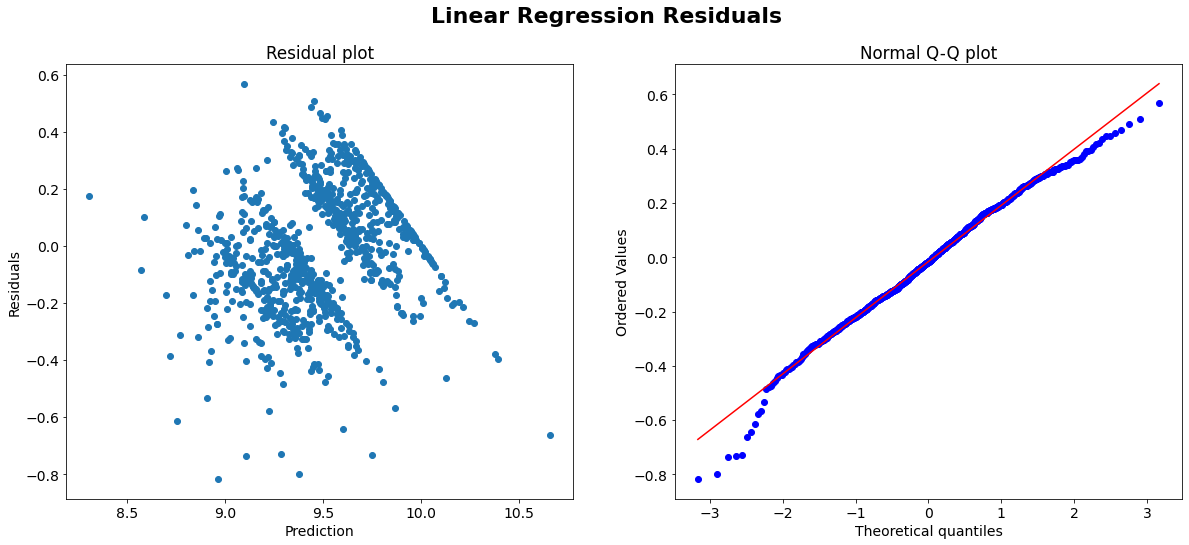

In [128]:
res_plots(regression_model_norm, x_test_norm, y_test, 'Linear Regression Residuals')

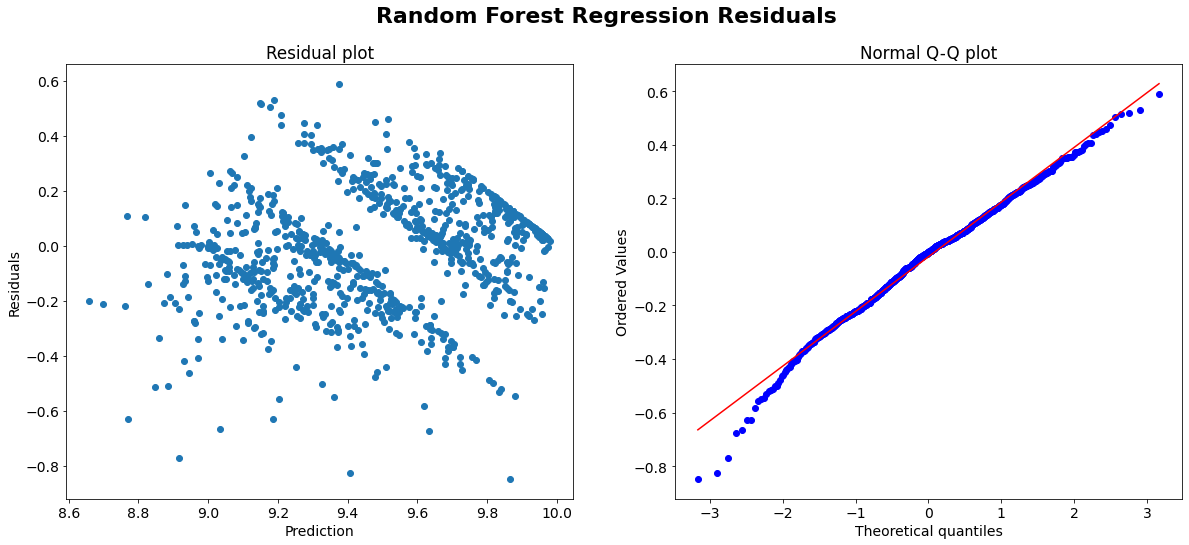

In [129]:
res_plots(rf_reg_norm, x_test_norm, y_test, 'Random Forest Regression Residuals')

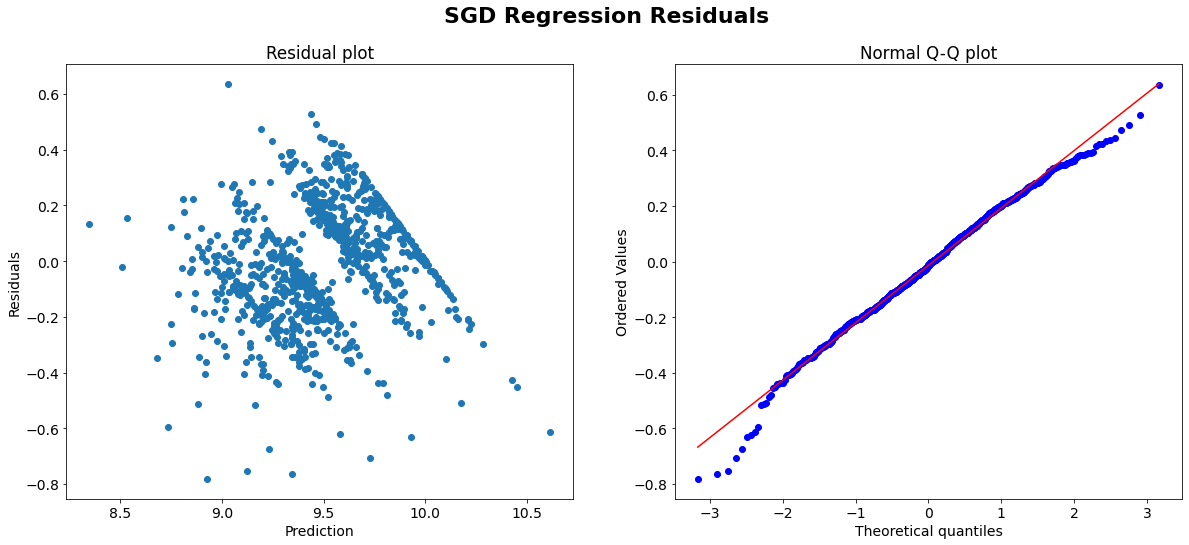

In [130]:
res_plots(sgd_reg_norm, x_test_norm, y_test, 'SGD Regression Residuals')

#### Linear Regression, Normalized Data - Feature Coefficients

In [131]:
# Create coefficient matrix using normalized data model (MinMaxScaler)
coefficient_dict = {'Feature' : list(x_train.columns), 'Coefficient' : regression_model_norm.coef_.flatten()}
coefficient_df = pd.DataFrame(coefficient_dict)
coefficient_df['Coefficient (ABS)'] = np.abs(coefficient_df['Coefficient'])
coefficient_df['Coefficient Sign'] = np.where(coefficient_df['Coefficient'] <= 0, 'Negative', 'Positive')

coefficient_df.sort_values('Coefficient (ABS)', ascending=False, inplace=True)
coefficient_df

,Feature,Coefficient,Coefficient (ABS),Coefficient Sign
2,sig_strike_land_disparity,1.453120,1.453120,Positive
4,takedown_land_disparity,1.254644,1.254644,Positive
7,ctrl_time_disparity,0.675325,0.675325,Positive
0,kd_disparity,0.646958,0.646958,Positive
5,takedown_att_disparity,-0.467516,0.467516,Negative
1,sig_head_land_disparity,0.386173,0.386173,Positive
6,sub_att_disparity,0.365218,0.365218,Positive
3,total_strike_att_disparity,0.144188,0.144188,Positive


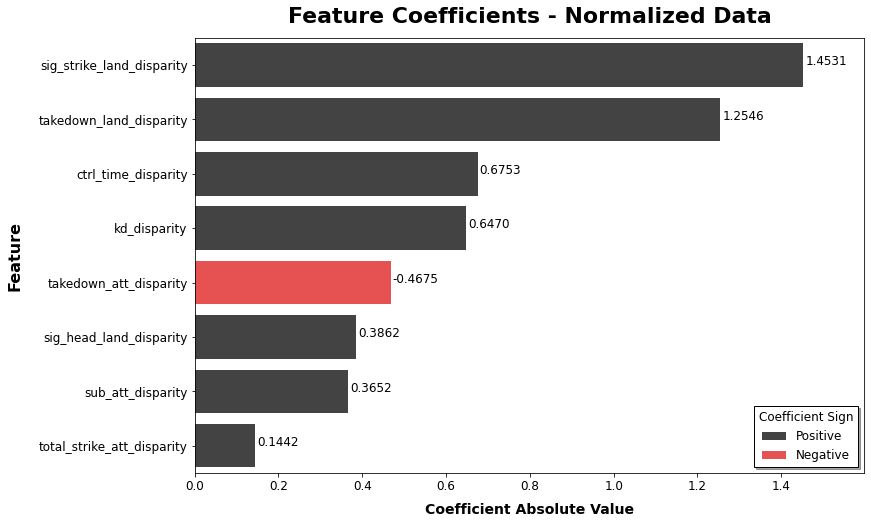

In [132]:
# Plot regression coefficient to show proxy of feature importance (normalized data)
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=[12,8])
plt.title('Feature Coefficients - Normalized Data', fontsize=22, fontweight='bold', pad=15)
plot = sns.barplot(x='Coefficient (ABS)', y='Feature', hue='Coefficient Sign', data=coefficient_df, dodge=False, palette=['#434343', '#FF3838'])
plt.xlim((0, coefficient_df['Coefficient (ABS)'].max() *1.1))
plt.legend(title='Coefficient Sign', loc='lower right', fancybox=False, shadow=True, edgecolor='black')
plt.ylabel('Feature', fontsize=16, fontweight='bold', labelpad=16)
plt.xlabel('Coefficient Absolute Value', fontsize=14, fontweight='bold', labelpad=10)

y = 0
for coef in coefficient_df['Coefficient']:
    plot.text(abs(coef) + .005, y, format(coef, '0.4f'), color='black', ha="left")
    y += 1
    
plt.show();

#### Linear Regression, Normalized Data - Winner Prediction

In [133]:
# Use winner_accuracy table to plot predicted vs. actual scores
winner_pred_reg_norm['correct'] = np.where(winner_pred_reg_norm['correct'] == 0, 'Incorrect', 'Correct')

Text(0.5, 0, 'Actual Per Round Score')

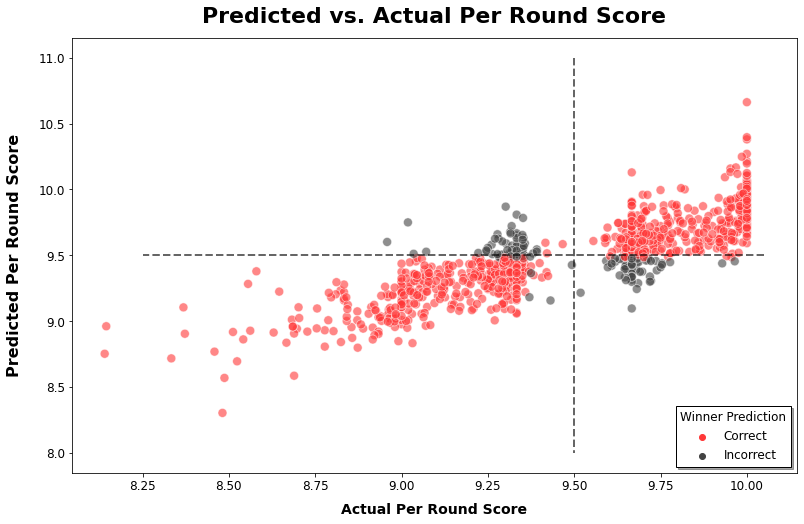

In [134]:
plt.figure(figsize=[13,8])
plt.title('Predicted vs. Actual Per Round Score', fontsize=22, fontweight='bold', pad=15)

sns.scatterplot(x='combined_avg', y='prediction', data=winner_pred_reg_norm, hue='correct', s=80, linewidths=.7, edgecolors='black', alpha=0.6, palette=['#FF3838', '#434343'])
plt.plot([9.5, 9.5], [11.0, 8.0], linewidth=2, linestyle='--', color='black', alpha=0.6)
plt.plot([10.05, 8.25], [9.5, 9.5], linewidth=2, linestyle='--', color='black', alpha=0.6)

plt.legend(title='Winner Prediction', loc='lower right', fancybox=False, shadow=True, edgecolor='black')
plt.ylabel('Predicted Per Round Score', fontsize=16, fontweight='bold', labelpad=16)
plt.xlabel('Actual Per Round Score', fontsize=14, fontweight='bold', labelpad=10)

#### Linear Regression, Normalized Data - Feature Distributions

In [135]:
normalized_data = pd.DataFrame(x_test_norm)
normalized_data.columns = x_test.columns
pred_vs_act_norm = pd.concat([winner_pred_reg_norm.reset_index(), normalized_data], axis=1)

In [136]:
pred_vs_act_norm.drop(columns=['combined_avg', 'prediction', 'index', 'actual_max', 'pred_max'], inplace=True)

In [137]:
pred_vs_act_norm_grouped = pred_vs_act_norm.groupby(['fight_id_fighter', 'correct']).sum()

In [138]:
stacked_normalized = pred_vs_act_norm_grouped.stack().reset_index()
stacked_normalized.rename(columns={'level_2' : 'metric', 0 : 'value'}, inplace=True)

In [139]:
stacked_normalized

,fight_id_fighter,correct,metric,value
0,0005e00b07cee542-578ef12674df1e6a,Correct,kd_disparity,0.500000
1,0005e00b07cee542-578ef12674df1e6a,Correct,sig_head_land_disparity,0.409790
2,0005e00b07cee542-578ef12674df1e6a,Correct,sig_strike_land_disparity,0.320423
3,0005e00b07cee542-578ef12674df1e6a,Correct,total_strike_att_disparity,0.363918
4,0005e00b07cee542-578ef12674df1e6a,Correct,takedown_land_disparity,0.425000
...,...,...,...,...
7179,ffd8e8575a551875-4e06913c91da5200,Correct,total_strike_att_disparity,0.524055
7180,ffd8e8575a551875-4e06913c91da5200,Correct,takedown_land_disparity,0.500000
7181,ffd8e8575a551875-4e06913c91da5200,Correct,takedown_att_disparity,0.519231
7182,ffd8e8575a551875-4e06913c91da5200,Correct,sub_att_disparity,0.500000


In [140]:
linear_reg_data_filtered.describe()

,kd_disparity,sig_head_land_disparity,sig_strike_land_disparity,total_strike_att_disparity,takedown_land_disparity,takedown_att_disparity,sub_att_disparity,ctrl_time_disparity,combined_avg
count,4516.000000,4516.000000,4516.00000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000,4516.000000
mean,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9.480189
std,0.175165,7.740570,9.94359,23.866425,1.003535,2.246023,0.354823,99.060779,0.365100
min,-1.666667,-47.666667,-62.40000,-108.333333,-6.666667,-8.666667,-2.333333,-284.000000,8.140351
25%,0.000000,-4.333333,-6.00000,-14.616667,-0.666667,-1.333333,0.000000,-53.700000,9.214286
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,9.421053
75%,0.000000,4.333333,6.00000,14.616667,0.666667,1.333333,0.000000,53.700000,9.777778
max,1.666667,47.666667,62.40000,108.333333,6.666667,8.666667,2.333333,284.000000,10.000000


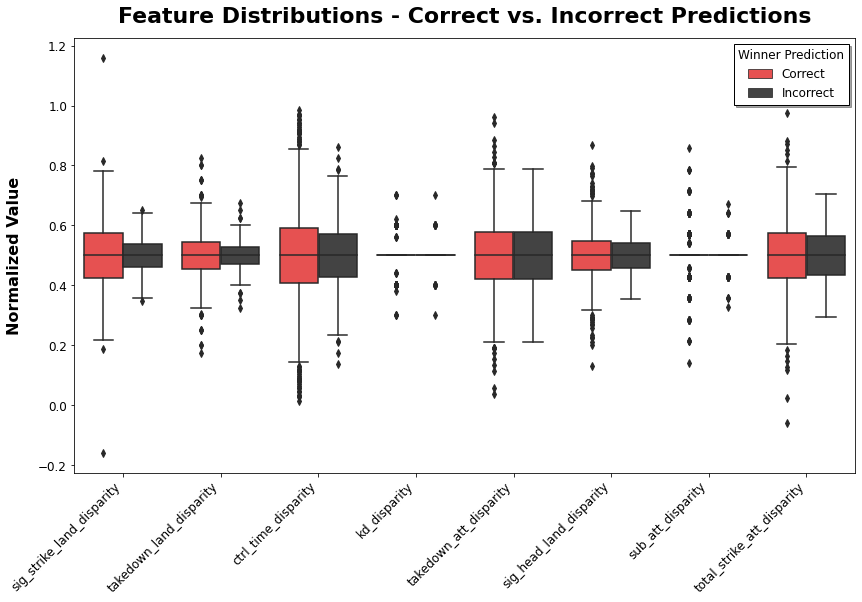

In [141]:
plt.figure(figsize=[14,8])
plt.title('Feature Distributions - Correct vs. Incorrect Predictions', fontsize=22, fontweight='bold', pad=15)
ax = sns.boxplot(x='metric', y='value', hue='correct', data=stacked_normalized, order=coefficient_df['Feature'],
                 showfliers=True, palette=['#FF3838', '#434343'])
plt.xticks(rotation=45, ha='right')
plt.legend(title='Winner Prediction', loc='upper right', fancybox=False, shadow=True, edgecolor='black')
plt.ylabel('Normalized Value', fontsize=16, fontweight='bold', labelpad=16)
plt.xlabel('')

plt.show();

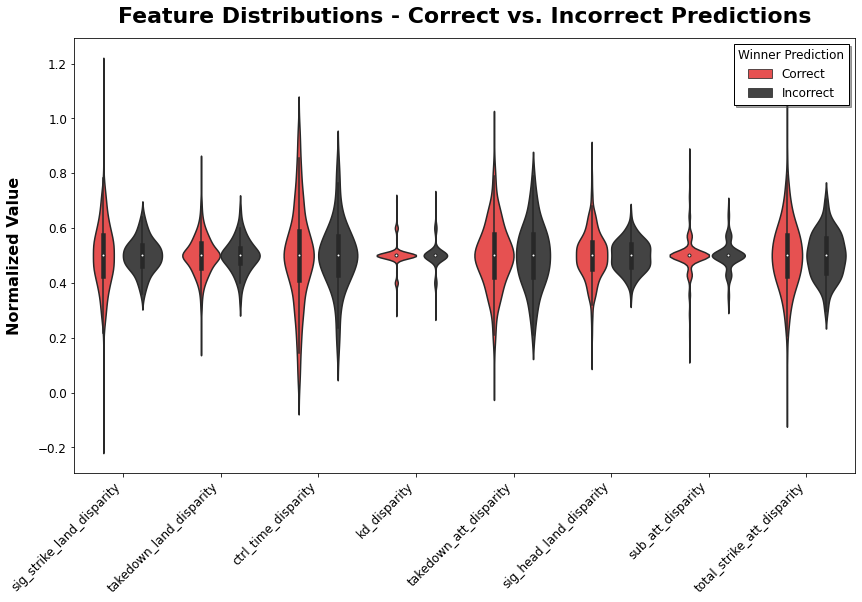

In [142]:
plt.figure(figsize=[14,8])
plt.title('Feature Distributions - Correct vs. Incorrect Predictions', fontsize=22, fontweight='bold', pad=15)
sns.violinplot(x='metric', y='value', hue='correct', data=stacked_normalized, order=coefficient_df['Feature'],
               showfliers=True, palette=['#FF3838', '#434343'])
plt.xticks(rotation=45, ha='right')
plt.legend(title='Winner Prediction', loc='upper right', fancybox=False, shadow=True, edgecolor='black')
plt.ylabel('Normalized Value', fontsize=16, fontweight='bold', labelpad=16)
plt.xlabel('')
plt.show();

#### 3D Rotation GIF

Through my search for visualization options for multivariate linear regression, I came across some code to produce 3D projections for 3-variable regression problems (2 independent, 1 dependent variable). The code below uses the two most fight metrics most predictive of scoring, sig_strike_land_disparity and takedown_land_disparity. It runs a new regression model and plots the a regression plane predicting the per round score of the given fighter. I then took 360 snapshots of the 3D plot, rotated 1 degree for each snapshot. These were stitched together to create a GIF used in my presentation.

In [56]:
sig_strike_min = linear_reg_data_filtered['takedown_land_disparity'].min()
sig_strike_max = linear_reg_data_filtered['takedown_land_disparity'].max()
takedown_min = linear_reg_data_filtered['ctrl_time_disparity'].min()
takedown_max = linear_reg_data_filtered['ctrl_time_disparity'].max()

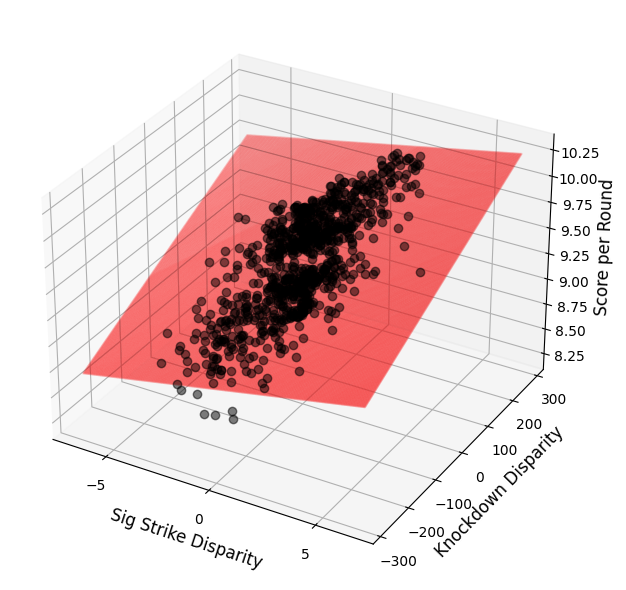

In [57]:
# Prep model for visualization
x = x_test['takedown_land_disparity']
y = x_test['ctrl_time_disparity']
z = y_test['combined_avg']

sig_strike_range = np.linspace(start=sig_strike_min, stop=sig_strike_max, num=len(x_test))
takedown_range = np.linspace(start=takedown_min, stop=takedown_max, num=len(x_test))
sig_strike_grid, takedown_grid = np.meshgrid(sig_strike_range, takedown_range)
model_viz = np.array([sig_strike_grid.flatten(), takedown_grid.flatten()]).T

# Instantiate and train new model
two_feature_model = LinearRegression()
two_feature_model.fit(x_train[['takedown_land_disparity', 'ctrl_time_disparity']], y_train)
predictions = two_feature_model.predict(model_viz)

# Evaluate the model
two_feature_score = two_feature_model.score(x_test[['takedown_land_disparity', 'ctrl_time_disparity']], y_test)

# Plot 3D projection
plt.style.use('default')

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, color='black', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.scatter(sig_strike_grid.flatten(), takedown_grid.flatten(), predictions.flatten(), facecolor=(0,0,0,0), s=0.0005, edgecolor='#FF3838')
ax.set_xlabel('Sig Strike Disparity', fontsize=12)
ax.set_ylabel('Knockdown Disparity', fontsize=12)
ax.set_zlabel('Score per Round', fontsize=12)
ax.locator_params(nbins=4, axis='x')
ax.locator_params(nbins=5, axis='x')

#fig.suptitle('Regression Model $R^2 = %.2f$' % two_feature_score, fontsize=20)

fig.tight_layout()

In [769]:
# Create 360 images for GIF
for i in np.arange(0, 360, 1):
    ax.view_init(elev=16, azim=i)
    fig.savefig('regression_image%d.png' % i)

#### Random Forest - Winner Prediction

In [342]:
# Obtain predictions for testing data
y_predict = rf_reg.predict(x_test)

# Create new df with y_test actuals and predictions
winner_accuracy_rf = y_test.copy(deep=True)
winner_accuracy_rf['prediction'] = y_predict

In [343]:
def correct_winner(df, upper, lower):
    df['correct'] = np.where(((df['prediction']>=upper) & (df['combined_avg']>=upper)) \
                             | ((df['prediction']<=lower) & (df['combined_avg']<=lower)), 
                             1, 0)
    
    return sum(df['correct']) / len(df)

In [344]:
# Calculate the actual average points per round for the full dataset
fighter_1_avg = np.mean(fights_df['combined_fighter1_avg'] / fights_df['rds_sched'].astype(float))
fighter_2_avg = np.mean(fights_df['combined_fighter2_avg'] / fights_df['rds_sched'].astype(float))
avg_per_rd = np.mean([fighter_1_avg, fighter_2_avg])
print('The average points per round in our dataset is: ' + str(format(avg_per_rd, '.3f')))

The average points per round in our dataset is: 9.480


In [345]:
# Estimate the accuracy for the model picking the correct winner
print('Threshold: 9.5, Model Accuracy: ' + str(format(correct_winner(winner_accuracy_rf, 9.5, 9.5),'.1%')))
print('Threshold: 9.48, Model Accuracy: ' + str(format(correct_winner(winner_accuracy_rf, avg_per_rd, avg_per_rd), '.1%')))
print('Threshold: 9.48 to 9.5, Model Accuracy: ' + str(format(correct_winner(winner_accuracy_rf, 9.5, avg_per_rd), '.1%')))

Threshold: 9.5, Model Accuracy: 80.9%
Threshold: 9.48, Model Accuracy: 80.9%
Threshold: 9.48 to 9.5, Model Accuracy: 80.7%


In [346]:
winner_accuracy_rf

,combined_avg,prediction,correct
fight_id_fighter,,,
0005e00b07cee542-578ef12674df1e6a,8.872000,8.492575,1
0005e00b07cee542-634e2fb70bde3fd5,10.000000,9.947794,1
00fbeda449926c13-547afe1017e72dbe,9.759259,9.963488,1
00fbeda449926c13-d6c0cdd7e467c440,8.962963,8.353689,1
014f1da2083ca174-7c7332319c14094c,9.250000,9.253790,1
...,...,...,...
fdfe4e7cb2d0b665-ccf5dc41417e9daf,9.424242,8.323516,1
ff467a5f06a91a0f-b1d19449397541dc,9.784314,9.949903,1
ff467a5f06a91a0f-c96d9178c9ed9e62,9.078431,8.502231,1


Text(0.5, 0, 'Actual Per Round Score')

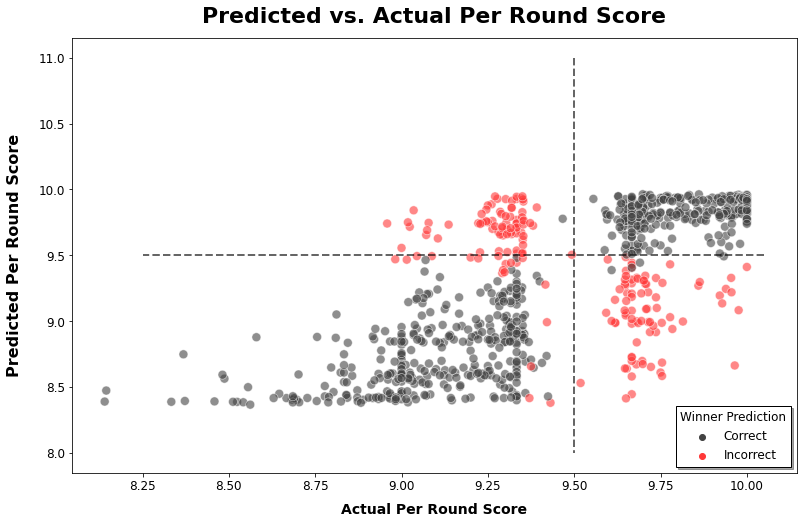

In [348]:
# Use winner_accuracy table to plot predicted vs. actual scores
winner_pred['correct'] = np.where(winner_pred['correct'] == 0, 'Incorrect', 'Correct')

plt.figure(figsize=[13,8])
plt.title('Predicted vs. Actual Per Round Score', fontsize=22, fontweight='bold', pad=15)

sns.scatterplot(x='combined_avg', y='prediction', data=winner_pred, hue='correct', s=80, linewidths=.7, 
                edgecolors='black', alpha=0.6, palette=['#434343', '#FF3838'])
plt.plot([9.5, 9.5], [11.0, 8.0], linewidth=2, linestyle='--', color='black', alpha=0.6)
plt.plot([10.05, 8.25], [9.5, 9.5], linewidth=2, linestyle='--', color='black', alpha=0.6)

plt.legend(title='Winner Prediction', loc='lower right', fancybox=False, shadow=True, edgecolor='black')
plt.ylabel('Predicted Per Round Score', fontsize=16, fontweight='bold', labelpad=16)
plt.xlabel('Actual Per Round Score', fontsize=14, fontweight='bold', labelpad=10)

#### Controversial Fights

In [74]:
# Top 10 Most Controversial Fights of 2020 
pairs = [['07f72a2a7591b409', '2e19380f34871c6a'],
         ['1338e2c7480bdf9e', 'f77c68bb4be8516d'],
         ['1ebe20ebbfa15e29', '3d6749c4267da18f'],
         ['e1248941344b3288', '150ff4cc642270b9'],
         ['193b9d1858bc4df3', 'e5010b1b94ca5755'],
         ['e1147d3d2dabe1ce', '9ce6d5a03af801b7'],
         ['82a5152216251682', '64a50dad704d1d49'],
         ['f2688492b9a525a3', '6bd02119599741a4'],
         ['efb96bf3e9ada36f', '7c7332319c14094c'],
         ['d28dee5c705991df', 'd967f0128c323de6']]

# https://www.mmaoddsbreaker.com/fight-odds/closing-odds/154151-ufc-betting-in-2020-looking-back-at-10-of-the-most-controversial-judging-decisions/

In [75]:
# Find fight id's in the data
fight_ids = []

for pair in pairs:
    ids = fights_df[((fights_df['fighter_1_id'] == pair[0]) & 
                     (fights_df['fighter_2_id'] == pair[1])) |
                    ((fights_df['fighter_1_id'] == pair[1]) & 
                     (fights_df['fighter_2_id'] == pair[0]))
                   ]['fight_id'].to_list()
    fight_ids.extend(ids)

In [76]:
# Drop irrelevant columns
keep_cols = ['fight_id', 'rds_sched', 'fighter_1_id', 'fighter_2_id', 'judge_fighter1_avg', 
             'judge_fighter2_avg', 'media_fighter1', 'media_fighter2', 'combined_fighter1_avg', 
             'combined_fighter2_avg']

controversial_fights = fights_df[fights_df['fight_id'].isin(fight_ids)][keep_cols]

In [77]:
# Check if controversial fights are in testing data (they all should be)
test_fights = [fight_id.split('-')[0] for fight_id in list(x_test.index)]
controversial_fights['tested'] = controversial_fights['fight_id'].isin(test_fights)

controversial_fights = controversial_fights[controversial_fights['tested'] == True]

In [78]:
# Merge model predictions to the dataframe
controversial_fights['fight_id_fighter1'] = controversial_fights['fight_id'] + '-' + controversial_fights['fighter_1_id']
controversial_fights['fight_id_fighter2'] = controversial_fights['fight_id'] + '-' + controversial_fights['fighter_2_id']

controversial_predictions = winner_pred_reg_norm[['fight_id_fighter', 'prediction']]

controversial_fights = pd.merge(controversial_fights, controversial_predictions, how='left', left_on='fight_id_fighter1', right_on='fight_id_fighter')
controversial_fights.rename(columns={'prediction' : 'prediction_fighter1'}, inplace=True)
controversial_fights = pd.merge(controversial_fights, controversial_predictions, how='left', left_on='fight_id_fighter2', right_on='fight_id_fighter')
controversial_fights.rename(columns={'prediction' : 'prediction_fighter2'}, inplace=True)

In [79]:
# Merge fighter names

In [80]:
fighters_df = query_to_df(DQ.get_fighter_names())

In [81]:
fighters_df['full_name'] = fighters_df['first_name'] + ' ' + fighters_df['last_name']

In [82]:
controversial_fights = pd.merge(controversial_fights, fighters_df[['fighter_id', 'full_name']], how='left', left_on='fighter_1_id', right_on='fighter_id')
controversial_fights.rename(columns={'full_name' : 'full_name_fighter1'}, inplace=True)
controversial_fights = pd.merge(controversial_fights, fighters_df[['fighter_id', 'full_name']], how='left', left_on='fighter_2_id', right_on='fighter_id')
controversial_fights.rename(columns={'full_name' : 'full_name_fighter2'}, inplace=True)

In [83]:
controversial_tidy = controversial_fights[['full_name_fighter1', 'full_name_fighter2',
                                           'rds_sched',
                                           'judge_fighter1_avg', 'judge_fighter2_avg',
                                           'media_fighter1', 'media_fighter2',
                                           'combined_fighter1_avg', 'combined_fighter2_avg',
                                           'prediction_fighter1', 'prediction_fighter2'
                                          ]]

In [85]:
controversial_tidy['judge_fighter1_avg'] = controversial_tidy['judge_fighter1_avg'] / controversial_tidy['rds_sched'].astype(int)
controversial_tidy['judge_fighter2_avg'] = controversial_tidy['judge_fighter2_avg'] / controversial_tidy['rds_sched'].astype(int)
controversial_tidy['media_fighter1'] = controversial_tidy['media_fighter1'] / controversial_tidy['rds_sched'].astype(int)
controversial_tidy['media_fighter2'] = controversial_tidy['media_fighter2'] / controversial_tidy['rds_sched'].astype(int)
controversial_tidy['combined_fighter1_avg'] = controversial_tidy['combined_fighter1_avg'] / controversial_tidy['rds_sched'].astype(int)
controversial_tidy['combined_fighter2_avg'] = controversial_tidy['combined_fighter2_avg'] / controversial_tidy['rds_sched'].astype(int)

In [86]:
controversial_tidy.columns = ['Fighter 1', 'Fighter 2', 'Rounds', 'Judges - Fighter 1', 'Judges - Fighter 2', 'Media - Fighter 1',
                              'Media - Fighter 2', 'Combined - Fighter 1', 'Combined - Fighter 2', 'Prediction - Fighter 1', 'Prediction - Fighter 2']

,full_name_fighter1,full_name_fighter2,rds_sched,judge_fighter1_avg,judge_fighter2_avg,media_fighter1,media_fighter2,combined_fighter1_avg,combined_fighter2_avg,prediction_fighter1,prediction_fighter2
0,Jon Jones,Dominick Reyes,5,9.666667,9.333333,9.600000,9.400000,9.608333,9.391667,9.437703,9.529021
1,Paul Felder,Dan Hooker,5,9.466667,9.533333,9.411765,9.600000,9.420000,9.590000,9.372324,9.594400
2,Stipe Miocic,Daniel Cormier,5,9.733333,9.266667,9.638462,9.369231,9.648276,9.358621,9.584272,9.382452
3,Pedro Munhoz,Frankie Edgar,5,9.533333,9.466667,9.330435,9.669565,9.353846,9.646154,9.572164,9.394561
4,Israel Adesanya,Yoel Romero,5,9.666667,9.333333,9.600000,9.411111,9.609524,9.400000,9.525636,9.441088
5,Alexander Volkanovski,Max Holloway,5,9.533333,9.466667,9.600000,9.400000,9.593333,9.406667,9.635076,9.331648
6,Robert Whittaker,Darren Till,5,9.600000,9.400000,9.640000,9.380000,9.634783,9.382609,9.617081,9.349643
7,Dan Ige,Edson Barboza,3,9.555556,9.444444,9.666667,9.333333,9.650794,9.349206,9.441383,9.525342
8,Song Yadong,Marlon Vera,3,9.666667,9.333333,9.686275,9.313725,9.683333,9.316667,9.490891,9.475833
9,Max Holloway,Alexander Volkanovski,5,9.266667,9.733333,9.252632,9.736842,9.254545,9.736364,9.438837,9.527887


# Appendices

#### Random Forest Parameter Tuning

In [159]:
def optimal_parameters(x_train, x_test, y_train, y_test, bootstrap=[True], max_depth=[None], max_features=['auto'],
                       min_samples_leaf=[1], min_samples_split=[2], n_estimators=[100]):
    """
    Accept parameter options in lists and return sorted dataframe of parameter combos and their R2 scores.
    """
    
    parameter_combos = pd.DataFrame()
    
    for combo in product(bootstrap, max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators):
        rf_regressor = RandomForestRegressor(random_state=0,
                                             bootstrap=combo[0],
                                             max_depth=combo[1],
                                             max_features=combo[2],
                                             min_samples_leaf=combo[3],
                                             min_samples_split=combo[4],
                                             n_estimators=combo[5]
                                            )

        rf_regressor.fit(x_train, y_train)
        y_pred = rf_regressor.predict(x_test)
        score = r2_score(y_test, y_pred)

        test_instance = {'combo' : combo, 'score' : score}
        parameter_combos = parameter_combos.append(test_instance, ignore_index=True)

    sorted_parameter_combos = parameter_combos.sort_values('score', ascending=False).reset_index()
    
    return sorted_parameter_combos

In [160]:
# Slice data for before and after cutoff data for train test split
train_cutoff = '2017-07-20'
validation_cutoff = '2019-07-25'
before = linear_reg_data_filtered[linear_reg_data_filtered['event_date'] < train_cutoff]
after = linear_reg_data_filtered[(linear_reg_data_filtered['event_date'] >= train_cutoff)
                                 &(linear_reg_data_filtered['event_date'] < validation_cutoff)]

# Split data to training and testing data using time based cutoff
x_train = before.drop(columns=['combined_avg', 'fight_id', 'event_date'], axis = 1)
x_test = after.drop(columns=['combined_avg', 'fight_id', 'event_date'], axis = 1)
y_train = before[['combined_avg']]
y_test = after[['combined_avg']]

# Normalized data
mm_scale = MinMaxScaler()
x_train_norm = mm_scale.fit_transform(x_train)
x_test_norm = mm_scale.transform(x_test)

In [161]:
# Complete parameter list
bootstrap = [True, False]
max_depth = [None, 10, 25, 50, 100]
max_features = ['auto', 'sqrt', 'log2']
min_samples_leaf = [1, 5, 10, 15, 20, 50]
min_samples_split = [2, 5, 10]#, 15, 20, 50]
n_estimators = [100, 200, 300, 600]

In [162]:
# Trimmed parameter list
bootstrap = [True]
max_depth = [10]
max_features = ['auto']
min_samples_leaf = [5]
min_samples_split = [10, 15, 20]
n_estimators = [180, 200, 220, 240]

In [163]:
# Final parameters
bootstrap = [True]
max_depth = [10]
max_features = ['auto']
min_samples_leaf = [5] # value of 1 leads to overfitting
min_samples_split = [20]
n_estimators = [220]

In [165]:
parameter_combos = optimal_parameters(x_train_norm, 
                                      x_test_norm,
                                      y_train,
                                      y_test,
                                      bootstrap=bootstrap,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split,
                                      n_estimators=n_estimators
                                     )

#### Brute Force Feature Selection